## Preface

Upon comparing San Diego's COVID trend to other major cities, I found that the new daily cases of riverside drastically dropped down at 7/17/20, which is the date that the Trump administration issued a change in COVID data management from the CDC to the HHSA. There has been much speculation about the transparency of the HHSA's release of COVID data, and the outlier of riverside inspired the initiative to examine if there are other major counties in the US that has a drastic drop in COVID data around the same time. 

## Data Import

In [2]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from itertools import chain 

In [3]:
df_covid = pd.read_csv('Datasets/COVID-19_Statistics_by_Jurisdiction.csv')
## https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-by-jurisdiction?geometry=-120.348%2C32.566%2C-115.965%2C33.372
df_population = pd.read_csv('Datasets/sub-est2019_6.csv', encoding = 'latin-1')
ca_population = pd.read_csv('Datasets/sub-est2019_6.csv', encoding = 'latin-1')
ca_covid = pd.read_csv('Datasets/statewide_cases.csv')

## Data Cleaning

In [4]:
## changing covid's lastupdate to just the date 
lastUpdate = df_covid['lastupdate']
update = []
for t in lastUpdate:
    ##getting rid of the time 
    date = t.split(' ')[0]
    #print(date)
    update.append(datetime.strptime(date, '%Y/%m/%d'))

df_covid['date'] = update

In [5]:
#df_covid['date'].iloc[0].weekday()
## adding day of the week to df covid 
weekday = []
for d in df_covid['date']:
    weekday.append(str(d.isoweekday()))



In [6]:
df_covid['dayOfWeek'] = weekday
##convert time into str for date 
new_date =[]
for e in df_covid.loc[:, 'date']:
    new_date.append(e.strftime('%m-%d'))

df_covid['date'] = new_date
##leaving only the useful columns  for covid
cols = ['name', 'confirmedcases', 'date', 'dayOfWeek']
df_covid = df_covid[cols]

##cleaning Name to title 
df_covid['name'] = df_covid['name'].str.title()
df_covid.rename({'name' : 'City'}, inplace = True, axis = 1)

##City is Unknown, most likely an input error
df_covid = df_covid.dropna()

cities_list = ['San Diego','San Francisco', 'Riverside', 'Imperial', 'Los Angeles', 'Sacramento', 'Orange', 'Santa Clara']

ca_covid = ca_covid.loc[ca_covid['county'].isin(cities_list)]

## clean date columns
ca_covid['date'] = ca_covid['date'].str.replace('2020-','')

In [7]:
df_population = df_population[['NAME', 'POPESTIMATE2019']]
df_population.columns = ['City', 'Population']

##clean City column 
df_population['City'] = df_population['City'].str.replace('city', '')
df_population['City'] = df_population['City'].str.replace('town', '')
df_population['City'] = df_population['City'].str.strip()
df_population.drop_duplicates(inplace = True)


#df_population['City'].value_counts()

##getting df population with only cities in df_covid
cities = df_covid['City'].unique()

df_population = df_population[df_population['City'].isin(list(cities))]
df_population = df_population[['City', 'Population']]
#df_population.head()

## merging these datasets 
df_covid_pop = df_population.merge(df_covid, left_on='City', right_on='City', how = 'inner')
df_covid_pop = df_covid_pop.sort_values(by=['City', 'date'])
cities = list(df_covid_pop['City'].unique())
#cities

##forloop to get the dailycases per city
daily = []
for c in list(cities):
    #print(c)
    df_temp = df_covid_pop.loc[df_covid_pop['City'] == c, :]
    diff = df_temp['confirmedcases'] - df_temp['confirmedcases'].shift(1)
    #print(len(diff))
    daily.append(list(diff))

daily = list(chain.from_iterable(daily))
df_covid_pop['DailyCases'] = daily

#df_covid_pop.tail()  
## creating confirmed cases per million column 
df_covid_pop['DailyCases/Million'] = (df_covid_pop['DailyCases']/df_covid_pop['Population']*1000000)
#df_covid_pop.head()

ca_population = ca_population[['NAME', 'POPESTIMATE2019']]
ca_population.columns = ['City', 'Population']

##clean City column 
ca_population['City'] = ca_population['City'].str.replace('city', '')
ca_population['City'] = ca_population['City'].str.replace('town', '')
ca_population['City'] = ca_population['City'].str.strip()
ca_population.drop_duplicates(inplace = True)


##getting df population with only cities in df_covid
ca_cities = cities_list
#print(ca_cities)

ca_population = ca_population[ca_population['City'].isin(list(ca_cities))]
ca_population = ca_population[['City', 'Population']]

## merging these datasets 
ca_covid = ca_population.merge(ca_covid, left_on='City', right_on='county', how = 'inner')
ca_covid = ca_covid.sort_values(by=['City', 'date'])
#cities = list(df_covid_pop['City'].unique())
#cities



In [8]:
ca_covid['DailyCases/Million'] = (ca_covid['newcountconfirmed']/df_covid_pop['Population']*1000000)


In [39]:
ca_covid.head()

,City,Population,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date,DailyCases/Million
0,Imperial,18120,Imperial,2.0,0.0,2,0,03-18,17.333726
1,Imperial,18120,Imperial,2.0,0.0,0,0,03-19,0.000000
2,Imperial,18120,Imperial,2.0,0.0,0,0,03-20,0.000000
3,Imperial,18120,Imperial,2.0,0.0,0,0,03-21,0.000000
4,Imperial,18120,Imperial,2.0,0.0,0,0,03-22,0.000000


## Data Analysis

In [154]:
def cal_covid(cities_list, days_before):
    aval = list(ca_covid['City'].unique())
    for c in list(cities_list):
        if c not in aval:
            print(c +" is not in the dataset")
            continue
        df_temp = ca_covid.loc[ca_covid['City'] == c, :]
        
        pv_temp = df_temp.iloc[-days_before:].pivot_table(index = 'date', values = 'DailyCases/Million')
       
       # print(type(pv_temp.index))
        #print(pv_temp.columns)
        date = pd.DataFrame.to_numpy(pv_temp.index)
       # print(type(date))
        plt.plot(pv_temp, label = c)
        plt.ylabel("Daily Cases Per Million People" )
        plt.xlabel('Daily Cases by Weekday')
        #print(pv_temp.loc['date', :]
        plt.xticks(np.arange(6)*days_before/5, date[::int(days_before/6)])
        plt.title('Daily Cases Per Million People in SD and Adjacent Cities')
        plt.legend()
    

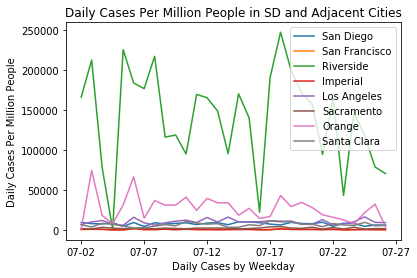

In [155]:
cal_covid(cities_list, 30)

In [31]:
np.arange(5)*15

array([ 0, 15, 30, 45, 60])

In [156]:
ca_covid.tail()

,City,Population,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date,DailyCases/Million
1083,Santa Clara,130365,Santa Clara,9157.0,184.0,171,0,07-27,6231.778426
1084,Santa Clara,130365,Santa Clara,9307.0,185.0,150,1,07-28,5466.472303
1085,Santa Clara,130365,Santa Clara,9567.0,187.0,260,2,07-29,9475.218659
1086,Santa Clara,130365,Santa Clara,9708.0,190.0,141,3,07-30,5138.483965
1087,Santa Clara,130365,Santa Clara,9863.0,191.0,155,1,07-31,5648.688047
